In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import seaborn           as sns
import os
import torch
import json
import sys

from pymatgen.core.structure         import Structure
from pymatgen.symmetry.bandstructure import HighSymmKpath

from libraries.model   import Helmholtz_free_energy_function, make_predictions, GCNN, compute_coefficients, compute_Fv
from libraries.dataset import load_atomic_masses, include_temperatures, create_predictions_dataset, standardize_dataset_from_keys

sys.path.append('../../UPC')
import MP.MP_library       as MPL

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()

/home/claudio/cibran/Work/UCL/ml-phasetransitions/../../UPC/MP/MP_library.py:193: SyntaxWarning: invalid escape sequence '\d'
  aux = re.split('(\d+)', component)


In [2]:
model_folder    = 'model'  # Pre-trained model and dataset parameters
output_folder   = 'output'  # Output files and figures
input_folder    = 'input'  # General files (e.g., atomic masses information)

# Whether to plot the harmonic extrapolations of Fv (very time-consuming) or not
plot_extrapolations = False

# Defining the range of temperatures
Ti = 300
Tf = 600
dT = 5
temperatures = np.arange(Ti, Tf+dT, dT)  # Temperatures for prediction of free-energies

# Loading dictionary of atomic masses
atomic_masses = load_atomic_masses(f'{input_folder}/atomic_masses.dat')

In [3]:
# Load the data from the JSON file
with open(f'{model_folder}/standardized_parameters.json', 'r') as json_file:
    numpy_dict = json.load(json_file)

# Convert NumPy arrays back to PyTorch tensors
standardized_parameters = {}
for key, value in numpy_dict.items():
    try:
        standardized_parameters[key] = torch.tensor(value)
    except:
        standardized_parameters[key] = value

# Load reference dataset for uncertainty estimation
reference_dataset = torch.load(f'{model_folder}/ref_std_dataset.pt', weights_only=False)

In [4]:
colors = ['b', 'r', 'g', 'k']

materials = {
    'CO': ['P2_12_12_1', 'R3c'],
    'Cs2Se': ['Pnma', 'R-3m'],
    'MgTe': ['F-43m', 'P6_3mc'],
    'SeN': ['C2-c', 'P2_1-c'],
    'SF6': ['C2-m', 'Im-3m'],
    'SrC2': ['C2-c', 'I4-mmm'],
    'WCl6': ['P-3m1', 'R-3'],
    'WN2': ['P3_121', 'Pna2_1'],
    'WSe2': ['P6_3-mmc', 'P-6m2'],
    'ZnCl2': ['P2_1-c', 'P4_2-nmc'],
    'ZnTe': ['F-43m', 'P6_3mc'],
    'ZrSeO': ['P2_13', 'P4-nmm']
}

offsets = {
    'CO': 0,
    'Cs2Se': 0,
    'MgTe': 0,
    'SeN': 0,
    'SF6': 0,
    'SrC2': 0,
    'WCl6': 0,
    'WN2': 0,
    'WSe2': 0,
    'ZnCl2': 0,
    'ZnTe': 0,
    'ZrSeO': 0
}

CO
P2_12_12_1
Is stable: False


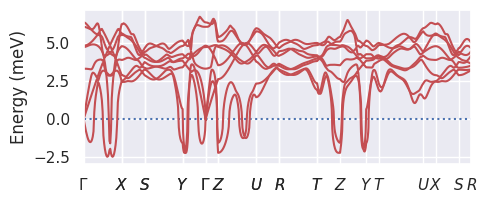

R3c


/home/claudio/cibran/Work/UCL/ml-phasetransitions/.venv/lib/python3.12/site-packages/pymatgen/symmetry/bandstructure.py:181: UserWarning: The input structure does not match the expected standard primitive! The path may be incorrect. Use at your own risk.
  kpath = KPathSetyawanCurtarolo(self._structure, symprec, angle_tolerance, atol)


Is stable: False


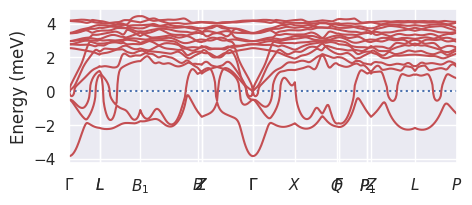

Cs2Se
Pnma
R-3m


/home/claudio/cibran/Work/UCL/ml-phasetransitions/.venv/lib/python3.12/site-packages/pymatgen/symmetry/bandstructure.py:181: UserWarning: The input structure does not match the expected standard primitive! The path may be incorrect. Use at your own risk.
  kpath = KPathSetyawanCurtarolo(self._structure, symprec, angle_tolerance, atol)


Is stable: False


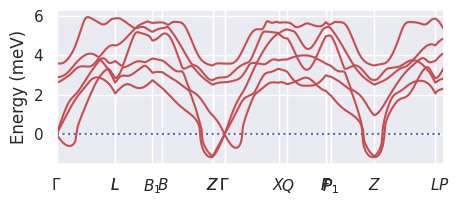

MgTe
F-43m


/home/claudio/cibran/Work/UCL/ml-phasetransitions/.venv/lib/python3.12/site-packages/pymatgen/symmetry/bandstructure.py:181: UserWarning: The input structure does not match the expected standard primitive! The path may be incorrect. Use at your own risk.
  kpath = KPathSetyawanCurtarolo(self._structure, symprec, angle_tolerance, atol)


Is stable: True


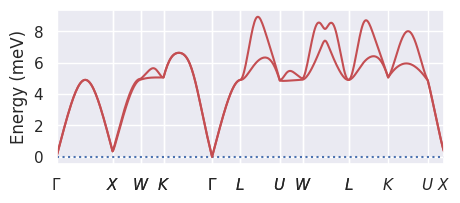

P6_3mc


/home/claudio/cibran/Work/UCL/ml-phasetransitions/.venv/lib/python3.12/site-packages/pymatgen/symmetry/bandstructure.py:181: UserWarning: The input structure does not match the expected standard primitive! The path may be incorrect. Use at your own risk.
  kpath = KPathSetyawanCurtarolo(self._structure, symprec, angle_tolerance, atol)


Is stable: True


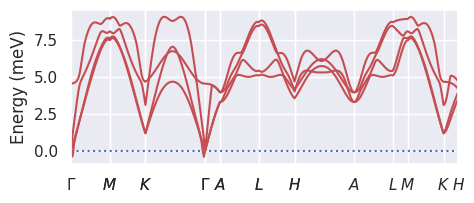

SeN
C2-c


/home/claudio/cibran/Work/UCL/ml-phasetransitions/.venv/lib/python3.12/site-packages/pymatgen/symmetry/bandstructure.py:181: UserWarning: The input structure does not match the expected standard primitive! The path may be incorrect. Use at your own risk.
  kpath = KPathSetyawanCurtarolo(self._structure, symprec, angle_tolerance, atol)


Is stable: False


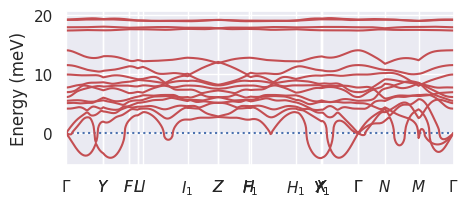

P2_1-c


/home/claudio/cibran/Work/UCL/ml-phasetransitions/.venv/lib/python3.12/site-packages/pymatgen/symmetry/bandstructure.py:181: UserWarning: The input structure does not match the expected standard primitive! The path may be incorrect. Use at your own risk.
  kpath = KPathSetyawanCurtarolo(self._structure, symprec, angle_tolerance, atol)


Is stable: False


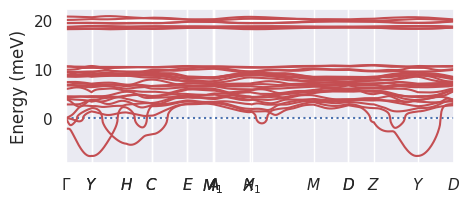

SF6
C2-m


/home/claudio/cibran/Work/UCL/ml-phasetransitions/.venv/lib/python3.12/site-packages/pymatgen/symmetry/bandstructure.py:181: UserWarning: The input structure does not match the expected standard primitive! The path may be incorrect. Use at your own risk.
  kpath = KPathSetyawanCurtarolo(self._structure, symprec, angle_tolerance, atol)


Is stable: False


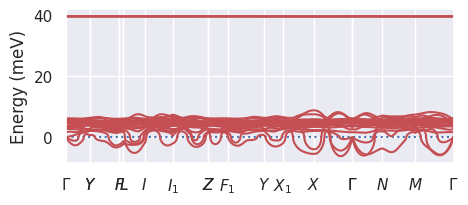

Im-3m


/home/claudio/cibran/Work/UCL/ml-phasetransitions/.venv/lib/python3.12/site-packages/pymatgen/symmetry/bandstructure.py:181: UserWarning: The input structure does not match the expected standard primitive! The path may be incorrect. Use at your own risk.
  kpath = KPathSetyawanCurtarolo(self._structure, symprec, angle_tolerance, atol)


Is stable: False


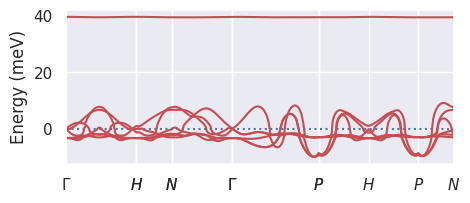

SrC2
C2-c


/home/claudio/cibran/Work/UCL/ml-phasetransitions/.venv/lib/python3.12/site-packages/pymatgen/symmetry/bandstructure.py:181: UserWarning: The input structure does not match the expected standard primitive! The path may be incorrect. Use at your own risk.
  kpath = KPathSetyawanCurtarolo(self._structure, symprec, angle_tolerance, atol)


Is stable: False


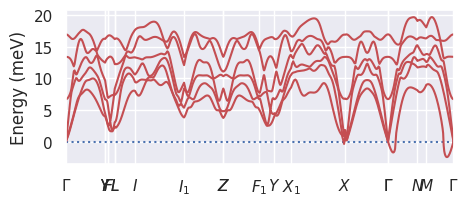

I4-mmm


/home/claudio/cibran/Work/UCL/ml-phasetransitions/.venv/lib/python3.12/site-packages/pymatgen/symmetry/bandstructure.py:181: UserWarning: The input structure does not match the expected standard primitive! The path may be incorrect. Use at your own risk.
  kpath = KPathSetyawanCurtarolo(self._structure, symprec, angle_tolerance, atol)


Is stable: False


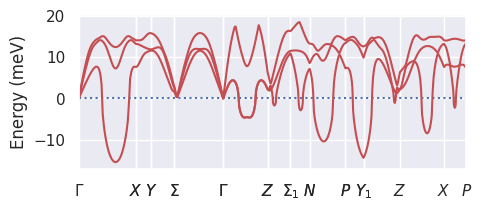

WCl6
P-3m1


/home/claudio/cibran/Work/UCL/ml-phasetransitions/.venv/lib/python3.12/site-packages/pymatgen/symmetry/bandstructure.py:181: UserWarning: The input structure does not match the expected standard primitive! The path may be incorrect. Use at your own risk.
  kpath = KPathSetyawanCurtarolo(self._structure, symprec, angle_tolerance, atol)


Is stable: False


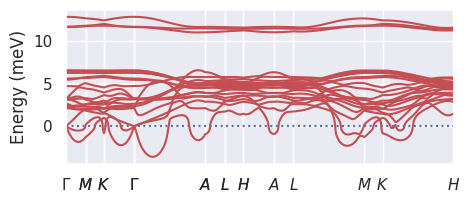

R-3


/home/claudio/cibran/Work/UCL/ml-phasetransitions/.venv/lib/python3.12/site-packages/pymatgen/symmetry/bandstructure.py:181: UserWarning: The input structure does not match the expected standard primitive! The path may be incorrect. Use at your own risk.
  kpath = KPathSetyawanCurtarolo(self._structure, symprec, angle_tolerance, atol)


Is stable: False


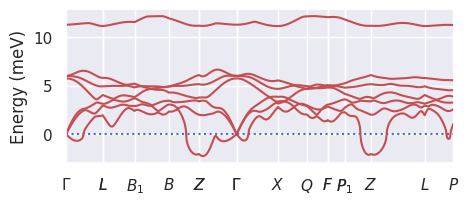

WN2
P3_121
Is stable: False


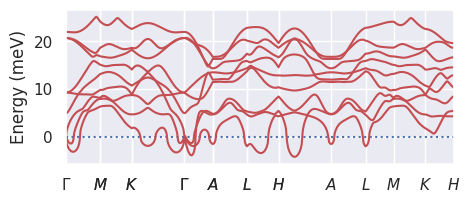

Pna2_1
Is stable: False


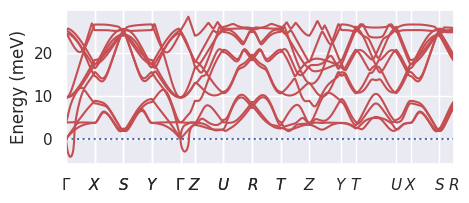

WSe2
P6_3-mmc


/home/claudio/cibran/Work/UCL/ml-phasetransitions/.venv/lib/python3.12/site-packages/pymatgen/symmetry/bandstructure.py:181: UserWarning: The input structure does not match the expected standard primitive! The path may be incorrect. Use at your own risk.
  kpath = KPathSetyawanCurtarolo(self._structure, symprec, angle_tolerance, atol)


Is stable: True


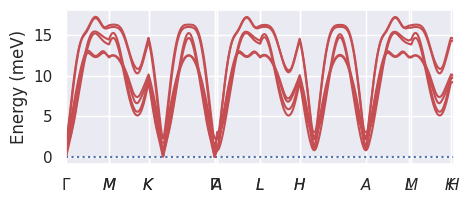

P-6m2


/home/claudio/cibran/Work/UCL/ml-phasetransitions/.venv/lib/python3.12/site-packages/pymatgen/symmetry/bandstructure.py:181: UserWarning: The input structure does not match the expected standard primitive! The path may be incorrect. Use at your own risk.
  kpath = KPathSetyawanCurtarolo(self._structure, symprec, angle_tolerance, atol)


Is stable: False


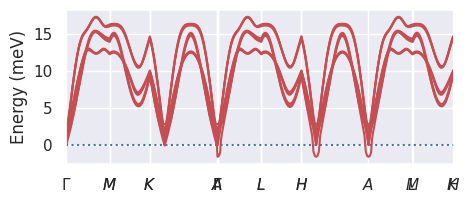

ZnCl2
P2_1-c


/home/claudio/cibran/Work/UCL/ml-phasetransitions/.venv/lib/python3.12/site-packages/pymatgen/symmetry/bandstructure.py:181: UserWarning: The input structure does not match the expected standard primitive! The path may be incorrect. Use at your own risk.
  kpath = KPathSetyawanCurtarolo(self._structure, symprec, angle_tolerance, atol)


Is stable: False


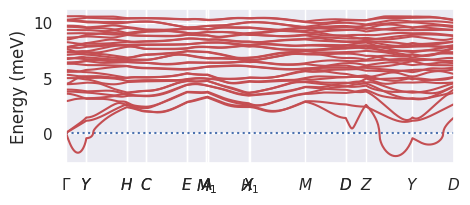

P4_2-nmc
Is stable: False


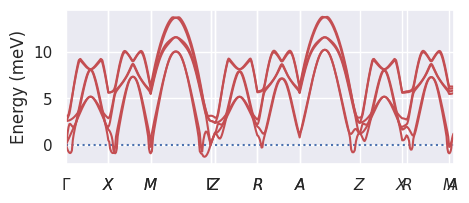

ZnTe
F-43m


/home/claudio/cibran/Work/UCL/ml-phasetransitions/.venv/lib/python3.12/site-packages/pymatgen/symmetry/bandstructure.py:181: UserWarning: The input structure does not match the expected standard primitive! The path may be incorrect. Use at your own risk.
  kpath = KPathSetyawanCurtarolo(self._structure, symprec, angle_tolerance, atol)


Is stable: True


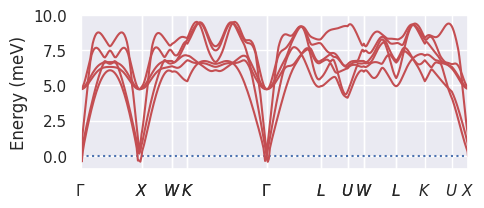

P6_3mc


/home/claudio/cibran/Work/UCL/ml-phasetransitions/.venv/lib/python3.12/site-packages/pymatgen/symmetry/bandstructure.py:181: UserWarning: The input structure does not match the expected standard primitive! The path may be incorrect. Use at your own risk.
  kpath = KPathSetyawanCurtarolo(self._structure, symprec, angle_tolerance, atol)


Is stable: True


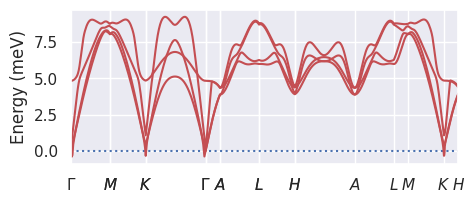

ZrSeO
P2_13
Is stable: True


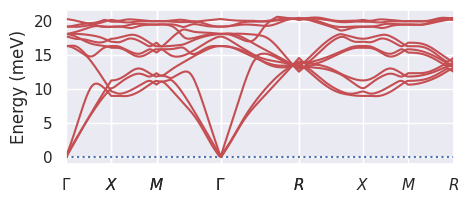

P4-nmm
Is stable: True


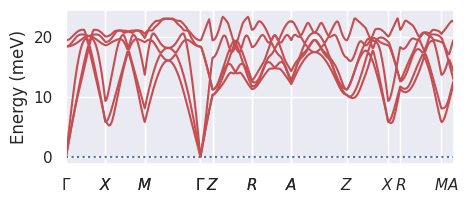

In [5]:
for material in materials.keys():
    print(material)

    polymorphs = materials[material]
    path_to_material = f'/home/claudio/Desktop/validation/{material}'
    
    for idx in range(len(polymorphs)):
        print(polymorphs[idx])
        
        path_to_polymorph = f'{path_to_material}/{polymorphs[idx]}'
        path_to_PHONON    = f'{path_to_polymorph}/phonons'

        # Check phonon bands

        # Loading number of atoms
        _, _, concentration, _ = MPL.information_from_VASPfile(path_to_PHONON, file='POSCAR')
        n_atoms = np.sum(concentration)

        # Reading supercell information
        dim_info = MPL.read_phonopyconf(path_to_PHONON)
        
        # Load POSCAR as pymatgen structure
        structure = Structure.from_file(f'{path_to_PHONON}/POSCAR')
        
        # Get kpoints and labels from a high-symmetry kpath
        kpoints, xlabels = HighSymmKpath(structure).get_kpoints()
        
        # Get high-symmetry indexes regarding generated lists
        idxs = [i for i, item in enumerate(xlabels) if item != '']
        
        # Concatenate, round and convert to str k-point positions
        xpositions_round = np.array([kpoints[i] for i in idxs])
        xpositions_round = np.round(xpositions_round, 3)
        xpositions       = list(np.array(np.concatenate(xpositions_round), dtype=str))
        
        # Get k-point labels
        xlabels = [f'${xlabels[i]}$' for i in idxs]
        
        # Write band.conf file (needed for phonopy)
        MPL.write_bandconf(path_to_PHONON, material, dim_info, xpositions, xlabels)
        
        # Get phonon bands with phonopy (ignoring output)
        previous_dir = os.getcwd()
        os.chdir(path_to_PHONON)
        os.system('phonopy -t band.conf > /dev/null')
        os.chdir(previous_dir)
    
        # Read the phonon bands; if branches are negative, the element is discarded
        try:
            xvalues, xvalues_hs, freq_matrix, is_stable = MPL.read_bandyaml(path_to_PHONON,
                                                                            xpositions_round,
                                                                            stability_threshold=-1
                                                                           )
        except FileNotFoundError:  # Some calculation not finished
            continue

        print(f'Is stable: {is_stable}')
        
        # Plot
        plt.figure(figsize=(5, 2))
        plt.plot([xvalues[0], xvalues[-1]], [0, 0], ':')
        for j in range(n_atoms):
            plt.plot(xvalues, freq_matrix[:, j], 'r')
        plt.xlim(xvalues[0], xvalues[-1])
        plt.xticks(xvalues_hs, xlabels)
        plt.ylabel('Energy (meV)')
        plt.savefig(f'{path_to_PHONON}/{material}-{polymorphs[idx]}-bands.png', dpi=300, bbox_inches='tight')
        plt.show()

In [ ]:
for material in materials.keys():
    print(material)

    polymorphs = materials[material]
    path_to_material = f'/home/claudio/Desktop/validation/{material}'
    
    for idx in range(len(polymorphs)):
        path_to_polymorph = f'{path_to_material}/{polymorphs[idx]}'
        path_to_EPA    = f'{path_to_polymorph}/phonons'
        path_to_POSCAR = f'{path_to_polymorph}/relaxation'
        path_to_PHONON = f'{path_to_EPA}'
        
    
        # PHONON
        
        # Loading number of atoms
        _, _, concentration, _ = MPL.information_from_VASPfile(path_to_PHONON, file='POSCAR')
        n_atoms = np.sum(concentration)
        
        # Reading supercell information
        dim_info = MPL.read_phonopyconf(path_to_PHONON)
        
        # Write mesh.conf file (needed for phonopy)
        MPL.write_meshconf(path_to_PHONON, material, dim_info, Ti, Tf, dT)
        
        # Getting thermal properties with phonopy (ignoring output)
        previous_dir = os.getcwd()
        os.chdir(path_to_PHONON)
        os.system('phonopy -t mesh.conf > /dev/null')
        os.chdir(previous_dir)
        
        # Read generated thermal properties (kJ/mol)
        try:
            _, Fv_PHONON = MPL.read_thermalpropertyyaml(len(temperatures), path_to_PHONON, thermalproperty='free_energy')
        except FileNotFoundError:  # Some calculation not finished
            sys.exit('PHONON calculation not finished.')
        
        # Pass kJ / molmp-1009220 to meV / atom
        conversion_factor = 1.6 * 6.022 * 0.01 * n_atoms
        Fv_PHONON        /= conversion_factor
        
        
        # ML

        # Create dataset for predictions
        dataset = create_predictions_dataset(path_to_POSCAR, path_to_material=True, path_to_polymorph=True)
        
        labels = [graph.label for graph in dataset]
    
        # Standardize properties
        std_dataset = standardize_dataset_from_keys(dataset, standardized_parameters)
    
        # Load Graph Neural Network model (making room for temperature as node attribute) to device
        # Dropout for initializing the model, not used at all while predicting
        model = GCNN(features_channels=dataset[0].num_node_features+1,
                     pdropout=0).to(device)
    
        # Free-up CUDA
        del dataset
    
        # Load and evaluate Graph Neural Network model
        model.load_state_dict(torch.load(f'{model_folder}/model.pt', map_location=torch.device(device)))
        model.eval()
    
        # Include temperatures
        std_dataset_w_temp = include_temperatures(std_dataset, temperatures, standardized_parameters)
    
        # Free-up CUDA
        del std_dataset
    
        # Compute predictions and corresponding uncertainties
        shot_predictions, shot_uncertainties = make_predictions(reference_dataset, std_dataset_w_temp, model, standardized_parameters)
    
        # Free-up CUDA
        del std_dataset_w_temp
    
        # Computing the coefficients and uncertainties from fitting
        coefficients = compute_coefficients(temperatures, shot_predictions, shot_uncertainties, s=0.5)
  
        # Compute Fv
        Fv_pred = compute_Fv(temperatures, coefficients)[0]
        
        
        # Plotting
                
        epa = float(np.loadtxt(f'{path_to_PHONON}/EPA')) * 1e3  # From eV/atom to meV/atom
        
        plt.plot(temperatures,     epa+Fv_PHONON+offsets[material], color=colors[idx], label=f'{polymorphs[idx]}')
        plt.errorbar(temperatures, epa+Fv_pred+offsets[material], color=colors[idx], yerr=shot_uncertainties, fmt=':o')
        
    plt.xlabel(r'$T$ (K)')
    plt.ylabel(r'$F_v$ (meV/atom)')
    plt.legend(loc='best')
    plt.savefig(f'{path_to_material}/{material}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
materials = {
    'MgTe': ['F-43m', 'P6_3mc'],
    'WSe2': ['P6_3-mmc', 'P-6m2'],
    'ZnCl2': ['P2_1-c', 'P4_2-nmc'],
    'ZnTe': ['F-43m', 'P6_3mc']
}